In [84]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18
import glob
from matplotlib.lines import Line2D

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs, process_img
from desi_lowz_funcs import calc_normalized_dist, sdss_rgb, get_scrollable_pdfs
from desi_lowz_funcs import find_objects_nearby, print_radecs
# from construct_dwarf_galaxy_catalogs import process_sga_matches

import warnings
from astropy.wcs import FITSFixedWarning

# Suppress just FITSFixedWarning
warnings.filterwarnings('ignore', category=FITSFixedWarning)


%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
from consolidate_photometry import consolidate_new_photo

In [239]:
cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")
cat = consolidate_new_photo(cat,sample="BGS_BRIGHT")


Need to rerun the shred catalog after having fixed the column name
Added PCNN values!
<class 'numpy.ndarray'>
<class 'astropy.table.column.Column'>
<class 'astropy.table.column.Column'>
<class 'astropy.table.column.Column'>
[ True False  True False False]
FRACTION REVERT BACK TO TRACTOR: 0.5352554952897517
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0031
MASKBIT=2^1, cog not converge, fraction: 0.059806
MASKBIT=2^2, bad resid, fraction : 0.0070
MASKBIT=2^3, cog curve decrease, fraction: 0.0124
MASKBIT=2^4, aperfrac-in image, fraction: 0.001570
MASKBIT=2^5, aperfrac-mask image, fraction: 0.047340
MASKBIT=2^6, image-frac mask, fraction: 0.000809
MASKBIT=2^7, bad colors, fraction: 0.000048
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.102151
MASKBIT=2^10, aper-cen masked, fraction: 0.049339
MASKBIT=2^12, near sga outski

In [240]:
file_path = cat[cat["TARGETID"] == 39627737203215046]["FILE_PATH"][0]
img_path = cat[cat["TARGETID"] == 39627737203215046]["IMAGE_PATH"][0]

cat_temp = cat[cat["TARGETID"] == 39627737203215046]
ra, dec, zred = cat_temp["RA"][0], cat_temp["DEC"][0], cat_temp["Z"][0]

print(file_path)
print(img_path)


/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-040m005-050p000/0473m020/BGS_BRIGHT_tgid_39627737203215046
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds_cutouts/image_tgid_39627737203215046_ra_47.378_dec_-2.018.fits


## Make first row images!

In [117]:
import matplotlib.patches as patches
from matplotlib.patches import Circle

In [118]:
## rgb image

img_data = fits.open(img_path)[0].data

rgb_img  = process_img(img_data,cutout_size=None)

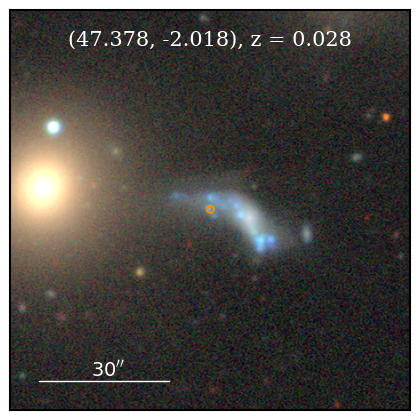

In [123]:
ax = make_subplots(ncol=1,nrow=1,plot_size=4)

ax[0].imshow(rgb_img,origin="lower")
ax[0].set_xticks([])
ax[0].set_yticks([])

fs=14
bar_size = 30/0.262
bar_start = 0.07*np.shape(rgb_img)[0]
y_bar = 0.07*np.shape(rgb_img)[0]

ax[0].plot([bar_start, bar_start+bar_size], [y_bar,y_bar],color = "white",lw = 1)
ax[0].text( bar_start + 0.4*bar_size, y_bar*1.15, r"$30''$",fontsize = fs,color = "white"  )

ax[0].text(0.5,0.925,f"({ra:.3f}, {dec:.3f}), z = {zred:.3f}",color = "white",fontsize = 15, 
               transform=ax[0].transAxes,va="center",ha="center")

circle = patches.Circle( (350/2, 350/2),3, color='darkorange', fill=False, linewidth=1.5,ls ="-")
ax[0].add_patch(circle)

plt.savefig("plots/photo_flowchart_rgb_img.png",bbox_inches="tight")

plt.show()

## Make a smoothed r band tractor model image

In [125]:
tractor_model = np.load(file_path + "/parent_galaxy_tractor_no_isolate_model.npy")

In [126]:
tractor_model.shape

(3, 350, 350)

In [127]:
r_rms = np.load(f"{file_path}/noise_per_band_rms.npy")[1]


In [128]:
from desi_lowz_funcs import process_img

In [129]:
cutout_size = 350
org_size = tractor_model.shape[1]

start = (org_size - cutout_size) // 2  # assumes square images
end = start + cutout_size
tractor_model = tractor_model[:, start:end, start:end]

#then 

In [130]:
from photutils.segmentation import make_2dgaussian_kernel
from astropy.convolution import convolve
from photutils.segmentation import detect_sources, deblend_sources

In [131]:
npixels_min = 10
threshold_rms_scale = 1.5

kernel = make_2dgaussian_kernel(15, size=29)  # FWHM = 3.0

threshold = threshold_rms_scale * r_rms
convolved_tot_data = convolve( tractor_model[1], kernel)

segment_map = detect_sources(convolved_tot_data, threshold, npixels=npixels_min) 


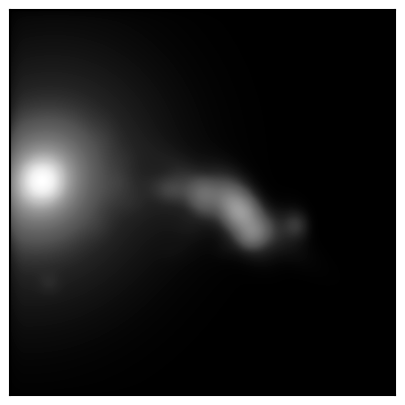

In [148]:
from desi_lowz_funcs import sdss_gray

convolved_tot_data_img = sdss_gray(convolved_tot_data, band="r")

plt.figure(figsize = (5,5))
plt.imshow(convolved_tot_data_img,origin="lower",cmap="Greys_r")
plt.xticks([])
plt.yticks([])
plt.savefig("plots/photo_flowchart_tractor_img.png",bbox_inches="tight")
plt.show()

## Plot the different apertures!!

In [221]:
reconstruct_galaxy_data = np.load(f"{file_path}/final_reconstruct_galaxy_no_cog_mask.npy")

reconstruct_galaxy_dict = { "g": reconstruct_galaxy_data[0], "r": reconstruct_galaxy_data[1], "z": reconstruct_galaxy_data[2] }

final_cog_mask = np.load(f"{file_path}/final_mask_cog_with_isolate.npy")



In [249]:
from matplotlib.colors import Normalize
import cmasher as cmr
from photutils.aperture import EllipticalAperture


In [253]:
aper_params = cat_temp["APER_PARAMS_FINAL"].data[0]

In [254]:
aper_params

array([27.69557796,  0.38599268, -0.48797781])

In [255]:
aper_xy_cen = cat_temp["APER_CEN_XY_PIX_FINAL"].data[0]

aper_xy_cen

array([201.80375488, 167.64693134])

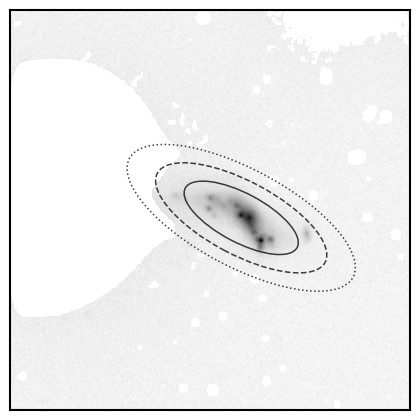

In [265]:
ax = make_subplots(ncol=1,nrow=1, plot_size=4)

combine_img = reconstruct_galaxy_dict["g"] + reconstruct_galaxy_dict["r"] + reconstruct_galaxy_dict["z"]
#setting the masked pixels to nans

combine_img[final_cog_mask] = np.nan

#instead of lognorm, let us do linear scaling
# norm_obj = LogNorm()
norm_obj = Normalize(vmin=np.nanmin(combine_img), vmax=np.nanmax(combine_img)) 

ax[0].imshow(combine_img,origin="lower",norm=norm_obj,zorder = 0,cmap=cmr.neutral_r)

##plott the apertures!!

ls_all = ["-","--","dotted"]
for i,si in enumerate([2,3,4]):
    draw_ellip_aper = EllipticalAperture( (aper_xy_cen[0], aper_xy_cen[1]) , si * aper_params[0], si * aper_params[0] * aper_params[1],
                                         theta=aper_params[2] )
    
    draw_ellip_aper.plot(ax = ax[0], color = "k", lw = 1.1, ls = ls_all[i],alpha = .75)

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.savefig("plots/photo_flowchart_cog_apers.png",bbox_inches="tight")

plt.show()

## Make rgb image of tractor isolate model for last row

In [150]:
tractor_isolate_model = np.load(f"{file_path}/parent_galaxy_tractor_isolate_model.npy")

In [187]:
parent_isolate_cat = Table.read(f"{file_path}/parent_galaxy_sources_isolate_FINAL.fits")

In [188]:
len(parent_isolate_cat)

16

In [153]:
isolate_rgb = sdss_rgb(tractor_isolate_model)

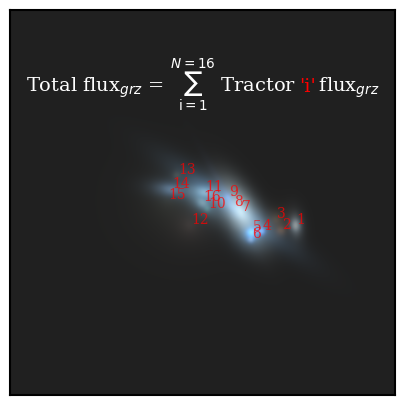

In [279]:
plt.figure(figsize = (5,5))
plt.imshow(isolate_rgb,origin="lower")
plt.xticks([])
plt.yticks([])

for i in range(len(parent_isolate_cat)):
    plt.text( parent_isolate_cat["xpix"][i], parent_isolate_cat["ypix"][i], f"{i+1}",
            color = "r",alpha=0.75)


plt.text(175,275,r"Total flux$_{grz}$ = $\sum_{\rm i=1}^{N=16}$ Tractor    flux$_{grz}$",
         fontsize = 14,color = "white",ha="center")

plt.text(270,275,r"'i'",
         fontsize = 14,color = "red",ha="center")

plt.savefig("plots/photo_flowchart_model_isolate_alternate.png",bbox_inches="tight")

plt.show()